In [1]:
import kagglehub

import matplotlib.pyplot as plt

import pandas as pd 

import re
from nltk.corpus import stopwords
import nltk

from nltk.stem import WordNetLemmatizer
from natasha import (
    MorphVocab,
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

from sentence_transformers import SentenceTransformer
import numpy as np

from openvino.runtime import Core
import openvino as ov
import torch

c:\Users\Mi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("carlosgdcj/genius-song-lyrics-with-language-information"
)

In [3]:
cols = ['title', 'tag', 'artist', 'year', 'views', 'lyrics', 'language']
by_views = []
en_num = 0
ru_num = 0

for chunk in pd.read_csv(path + '\\song_lyrics.csv', chunksize=100000, usecols=cols):
    filtered_chunk = chunk[chunk['language'].isin(['en', 'ru'])]
    by_views.append(filtered_chunk.groupby('views').size())

    en_num += filtered_chunk[filtered_chunk.language == 'en'].shape[0]
    ru_num += filtered_chunk[filtered_chunk.language == 'ru'].shape[0]

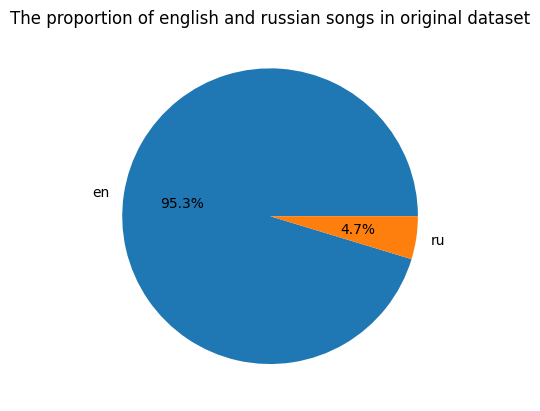

In [4]:
plt.pie([en_num, ru_num], labels=["en", "ru"], autopct='%1.1f%%')
plt.title("The proportion of english and russian songs in original dataset")
plt.show()

In [5]:
views_df = pd.concat(by_views).groupby(level=0).sum()
views_df = views_df[::-1].reset_index(name="cnt")
views_df["cmsm"] = views_df.cnt.cumsum()
views_df[views_df.cmsm >= 70000]

,views,cnt,cmsm
51695,23773,4,70001
51696,23772,1,70002
51697,23771,5,70007
51698,23770,5,70012
51699,23769,3,70015
...,...,...,...
75088,4,57681,3405800
75089,3,56109,3461909
75090,2,47497,3509406
75091,1,25926,3535332


**Top 70000 songs by views have at least 23773 views**

In [5]:
all = []

for chunk in pd.read_csv(path + '\\song_lyrics.csv', chunksize=100000, usecols=cols):
    filtered_chunk = chunk[(chunk['language'].isin(['en', 'ru'])) & (chunk.views >= 23773)]
    all.append(filtered_chunk)

In [10]:
all_df = pd.concat(all).reset_index(drop=True)

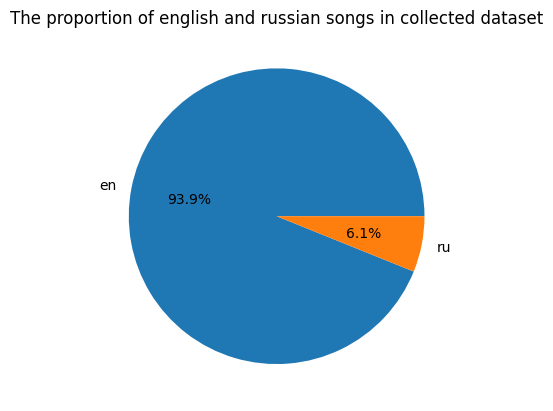

In [11]:
value_counts = all_df.language.value_counts()
plt.pie(value_counts, labels = value_counts.index, autopct='%1.1f%%')
plt.title("The proportion of english and russian songs in collected dataset")
plt.show()

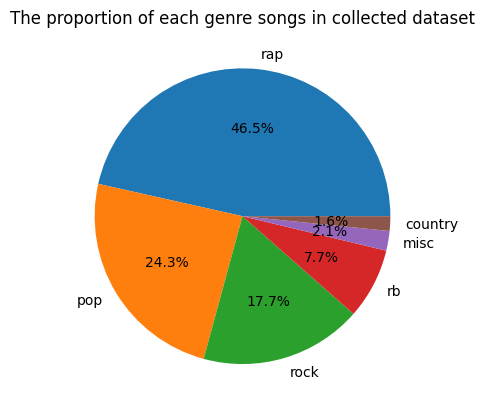

In [9]:
value_counts = all_df.tag.value_counts()
plt.pie(value_counts, labels = value_counts.index, autopct='%1.1f%%')
plt.title("The proportion of each genre songs in collected dataset")
plt.show()

We won't stratify the data because for our goal the popularity of the song is the critical factor.

In [12]:
all_df.to_csv('popular_songs.csv', index=False)

# Preprocessing

In [11]:
popular_songs = pd.read_csv('popular_songs.csv')

In [8]:
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')

stopwords_ru = set(stopwords.words('russian'))
stopwords_en = set(stopwords.words('english'))

# Natasha components
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
def remove_nested_brackets(text):
    while True:
        new_text = re.sub(r'\[[^\[\]]*\]', '', text)
        if new_text == text:
            break
        text = new_text
    return text

def preprocess_lyrics(lyrics, language):
    lyrics = lyrics.lower()
    lyrics = remove_nested_brackets(lyrics)
    
    if language == 'russian':
        doc = Doc(lyrics)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)

        processed_tokens = []
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
            lemma = token.lemma.lower()
            
            if (lemma not in stopwords_ru and 
                len(lemma) > 2):
                processed_tokens.append(lemma)

    else :
        tokens = re.findall(r"\b[\w']+\b", lyrics)
        lemmatized_tokens = [
            lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en and len(token) > 2
        ]

    return " ".join(lemmatized_tokens)

preprocessed_lyrics = popular_songs.copy()
preprocessed_lyrics["preprocessed_lyrics"] = popular_songs.apply(lambda x: preprocess_lyrics(x["lyrics"], x["language"]), axis=1)
preprocessed_lyrics.to_csv("preprocessed_lyrics.csv", index=False)

# Create embeddings

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

## Embeddings of unprocessed text

In [53]:
combined_texts = popular_songs.apply(
    lambda row: f"Artist: {row['artist']}. Genre: {row['tag']}. Year: {row['year']}. Language: {row['language']}. Lyrics: {row['lyrics']}",
    axis=1
)

In [ ]:
embeddings = model.encode(
    combined_texts.tolist(),
    convert_to_tensor=False,
    show_progress_bar=True
)

Batches: 100%|██████████| 2188/2188 [1:38:50<00:00,  2.71s/it]    


In [56]:
np.save('unprocessed_embeddings.npy', embeddings)

## Embeddings of processed text

In [4]:
preprocessed_lyrics = pd.read_csv('preprocessed_lyrics.csv')

In [5]:
combined_processed_texts = preprocessed_lyrics.apply(
    lambda row: f"Artist: {row['artist']}. Genre: {row['tag']}. Year: {row['year']}. Language: {row['language']}. Lyrics: {row['preprocessed_lyrics']}",
    axis=1
)

In [6]:
processed_embeddings = model.encode(
    combined_processed_texts.tolist(),
    convert_to_tensor=False,
    show_progress_bar=True
)

Batches: 100%|██████████| 2188/2188 [46:38<00:00,  1.28s/it]    


In [7]:
np.save('processed_embeddings.npy', processed_embeddings)

## How to access

In [8]:
unprocessed_embeddings = np.load('unprocessed_embeddings.npy')

# FAISS

In [27]:
import faiss

d_original = processed_embeddings.shape[1]
d_reduced = 128
n_samples = processed_embeddings.shape[0]

pca = faiss.PCAMatrix(d_original, d_reduced)
pca.train(processed_embeddings)

data_pca_processed = pca.apply_py(processed_embeddings)

pca.train(unprocessed_embeddings)

data_pca_unprocessed = pca.apply_py(unprocessed_embeddings)


# index = faiss.IndexFlatL2(d_reduced)
# index.add(data_pca)

# user_query = "I'm a bad guy"
# query_embedding = model.encode([user_query], convert_to_tensor=False)
# query_pca = pca.apply_py(query_embedding)
# D, I = index.search(query_pca, k=5)

# print("Nearest neighbors:", I)
# print("Distances:", D)

In [28]:
np.save('processed_embeddings_short.npy', data_pca_processed)

In [29]:
np.save('unprocessed_embeddings_short.npy', data_pca_unprocessed)

# Cosine similarity

In [ ]:
user_query = "I'm a bad guy"
query_embedding = model.encode([user_query], convert_to_tensor=False)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(query_embedding, processed_embeddings)
best_match_idx = similarities.argmax()  # Index of most similar document
print(f"Best match: {popular_songs.loc[best_match_idx]}")

Best match: title                                                 All Bad
tag                                                        rb
artist                                          Justin Bieber
year                                                     2013
views                                                  119158
lyrics      [Verse 1]\nIt's another, if it ain't one thing...
language                                                   en
Name: 17473, dtype: object
